In [9]:
import matplotlib.pyplot as plt 
from CoolProp.CoolProp import PropsSI
import numpy as np
import pandas as pd


In [162]:
# reservoir aquifer pressure
aq_P = 70 # bar

# reservoir reference depth
aq_Z = -1217 # mTVDMSL

# injection pointo r base of CO2 column
base_CO2_Z = -1312 # m

# base of cement plug/barrier
barrier_Z = -562

#density brine
rho_brine = 1024 # kg/m3

#gravity acceleration
G_acc = 9.8067 # m/s2

#Create depth vector
top = 0
base = 1500

z = -np.linspace(top, base, 1+(base-top)*2)
df = pd.DataFrame(data={'depth':z})


def P_hyd(z, ref_Z, ref_P, rho = 1024, g = 9.8067):
    """
    Creates a hydrostatic gradient based on a given density that matches a reference pressure, depth point
    """

    P_offset = ref_P*1e5 + ref_Z*rho*g
    P = (-(z*g*rho) + P_offset) / 1e5
    return P

#Hydrostatic gradient



df['P_hyd'] = P_hyd(z=z, ref_P=aq_P, ref_Z=aq_Z)

#Temperature
Tgrad = 40/1000 #thermal gradient [m/degC]
T_sf = 4 #seafloor temperature [degC]
Z_sf = 312 #seafloor depth [m]

df['Temp'] = T_sf - (df['depth']+Z_sf)*Tgrad #geothermal temperature field






# hydrostatic pressure at CO2 base
base_CO2_Phyd = P_hyd(z=base_CO2_Z, ref_P=aq_P, ref_Z=aq_Z)

# hydrostatic pressure at barrier base
barrier_Phyd = P_hyd(z=barrier_Z, ref_P=aq_P, ref_Z=aq_Z)

#vertical height between base of CO2 and base of barrier
col_CO2_height = barrier_Z - base_CO2_Z

# CO2 column
df['CO2_h'] = df['depth'] - base_CO2_Z
df.loc[(df['CO2_h']<0) | (df['CO2_h']>col_CO2_height), 'CO2_h'] = 0

# delta z
df['dz'] = df.depth.diff()

# create a column for P
df['P'] = df['P_hyd']

# create a column for Pcap
df['dPcap'] = 0
df['Pcap'] = 0
df['rho_g'] = 0




query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')


for idx, row in query.iloc[::-1].iterrows():

    col_h  = row.CO2_h
    z = row.depth
    dz = row.dz
    T = row.Temp
    P_hyd = row.P_hyd

    if col_h == 0:
        P = P_hyd
        rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, "CO2")

        df.loc[idx, 'rho_g'] = rho_g
        Pcap = 0
        P_previous = P
    else:
        dPcap = -((rho_brine - rho_g)*dz*G_acc)/1e5


        Pcap += dPcap

        df.loc[idx, 'dPcap'] = dPcap
        df.loc[idx, 'Pcap'] = Pcap

        P = P_hyd + Pcap



        df.loc[idx, 'P'] = P
        
        rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, "CO2")

        if T < PropsSI('CO2', 'Tcrit')-273.15:
            pcrit = PropsSI('P','T',T+273.15,'Q',0,'CO2')

            if np.abs((P*1e5/pcrit)-1) < 0.0001:
                continue
            else:
                rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, "CO2")

            # try:
            #     rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, "CO2")
            #     # if np.abs(rho_previous-rho_g)>100:
            #     #     print(z, P, pcrit/1e5,T, rho_g)
            # except:
            #     print(z, P, pcrit/1e5,T)

            # if np.abs((P*1e5/pcrit)-1) < 0.000001:
            #     print(z, P, pcrit/1e5,T, rho_g)

        else:
            rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, "CO2")
        # if np.abs(p*1e5 - pcrit)/pcrit > 1e-6:
        #     print(P, T)
        # try:    
        
        df.loc[idx, 'rho_g'] = rho_g

        rho_previous = rho_g
            

        # except:
        #     print(P,T)
        #     continue







ValueError: Saturation pressure [6.86355e+06 Pa] corresponding to T [300.97 K] is within 1e-4 % of given p [6.86356e+06 Pa] : PropsSI("D","P",6863557.689,"T",300.97,"CO2")

In [136]:
query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')
query

,depth,P_hyd,Temp,CO2_h,dz,P,dPcap,Pcap,rho_g
562,-562.0,4.224502,14.00,750.0,-1.0,49.636045,0.019085,45.411543,154.942571
563,-563.0,4.324922,14.04,749.0,-1.0,49.717381,0.085183,45.392458,829.388040
564,-564.0,4.425343,14.08,748.0,-1.0,49.732619,0.019151,45.307276,155.383497
565,-565.0,4.525764,14.12,747.0,-1.0,49.813889,0.085139,45.288125,828.718906
566,-566.0,4.626184,14.16,746.0,-1.0,49.829170,0.019216,45.202986,155.824959
...,...,...,...,...,...,...,...,...,...
1308,-1308.0,79.138275,43.84,4.0,-1.0,79.444511,0.076551,0.306235,243.449181
1309,-1309.0,79.238696,43.88,3.0,-1.0,79.468380,0.076556,0.229684,243.397782
1310,-1310.0,79.339117,43.92,2.0,-1.0,79.492244,0.076561,0.153128,243.346515
1311,-1311.0,79.439537,43.96,1.0,-1.0,79.516104,0.076566,0.076566,243.295382


In [109]:
PropsSI('P','T',14.04+273.15,'Q',0,'CO2')

4970577.5944873

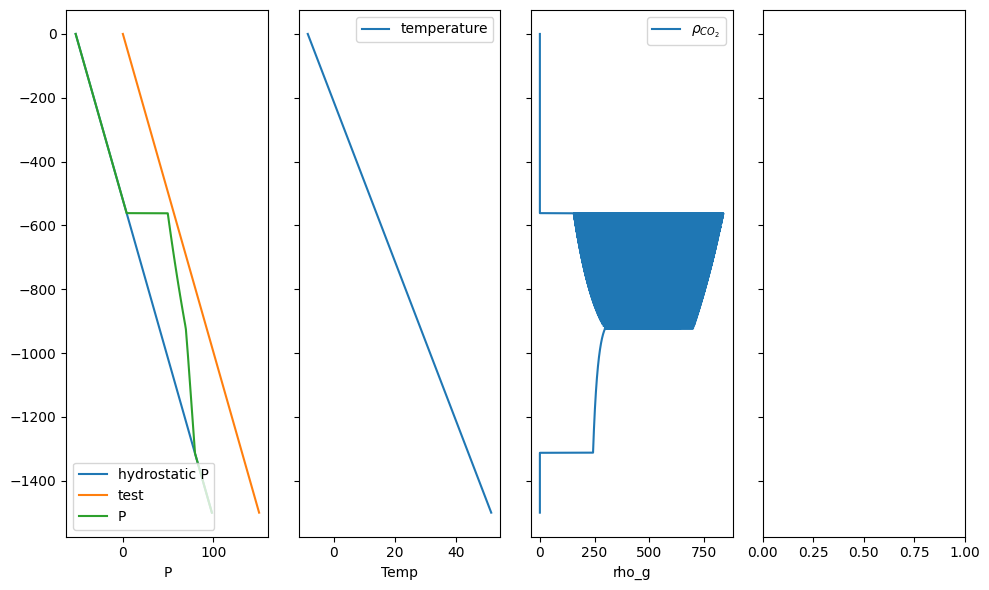

In [159]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey=True, figsize=(10, 6))

df.plot(x='P_hyd', y='depth', ax= ax1, label='hydrostatic P')

ax1.plot(-(df.depth*rho_brine*G_acc)/1e5, df.depth, label='test')

df.plot(x='P', y='depth', ax= ax1, label='P')
# ax1.plot(PFT['pressure'], -PFT['depth'], ls=':')

df.plot(x='Temp', y='depth', ax= ax2, label='temperature')
df.plot(x='rho_g', y='depth', ax= ax3, label=r'$\rho_{CO_2}$')

rho_g_0 = PropsSI("D", "P", df['P_hyd'].values*1e5, "T", df['Temp'].values+273.15, "CO2")
rho_g_f = PropsSI("D", "P", df['P'].values*1e5, "T", df['Temp'].values+273.15, "CO2")

# ax3.plot(rho_g_0, df.depth, '--')
# ax3.plot(rho_g_f, df.depth, '--')
# ax3.plot(PFT['rhog'], -PFT['depth'])


# ax4.plot(PFT['sgas'], -PFT['depth'])


ax1.legend(loc='lower left')

fig.tight_layout()

In [75]:
p, t = 50.18892050010725, 14.44

PropsSI("D", "P", p*1e5, "T", t+273.15, "CO2")

ValueError: Saturation pressure [5.0189e+06 Pa] corresponding to T [287.59 K] is within 1e-4 % of given p [5.01889e+06 Pa] : PropsSI("D","P",5018892.05,"T",287.59,"CO2")

In [79]:
pcrit = PropsSI('P','T',t+273.15,'Q',0,'CO2')

True

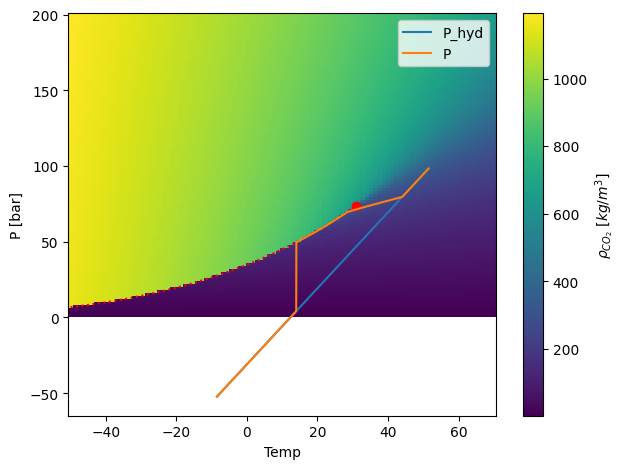

In [140]:
nx, ny = (101, 101)
T = np.linspace(-50, 70, nx)

P = np.linspace(1, 200, ny)
Tv, Pv = np.meshgrid(T, P)



Tv = Tv.flatten()
Pv = Pv.flatten()

density_coolprop = PropsSI("D", "P", Pv*1e5, "T", Tv+273.15, "CO2")



Pcrit = PropsSI('CO2', 'pcrit')
Tcrit = PropsSI('CO2', 'Tcrit')

Tphase = np.linspace(273.15-50, Tcrit, 2000)
Pphase = PropsSI('P','T',Tphase,'Q',0,'CO2')

Tv = Tv.reshape(nx, ny)
Pv = Pv.reshape(nx, ny)
density_coolprop = density_coolprop.reshape(nx, ny)

fig, ax = plt.subplots()

pcm = ax.pcolormesh(Tv, Pv, density_coolprop, shading='nearest')

ax.scatter(Tcrit-273.15, Pcrit/1e5, c='red', label='critical P,T')
ax.plot(Tphase-273.15, Pphase/1e5, c='red', ls=':')
ax.set_xlabel('T [$\degree$C]')
ax.set_ylabel('P [bar]')

df.plot(x='Temp', y='P_hyd', ax=ax)
df.plot(x='Temp', y='P', ax=ax)

fig.colorbar(pcm, label = r'$\rho_{CO_2}$ [$kg/m^3$]')

fig.tight_layout()

# fig.savefig('CO2_density.png')
